In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Create dataset

In [20]:
# load the data set and convert to dataframe
path="Simulator_readings.csv"
df=pd.read_csv(path)
df

,Time(ms),Fhr1(BPM),Fhr2(BPM),Uc(TOCO)
0,250,126,0,9
1,500,126,0,9
2,750,126,0,10
3,1000,126,0,10
4,1250,126,0,10
...,...,...,...,...
2395,599000,130,0,11
2396,599250,130,0,11
2397,599500,130,0,11
2398,599750,129,0,11


In [21]:
# info of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Time(ms)   2400 non-null   int64
 1   Fhr1(BPM)  2400 non-null   int64
 2   Fhr2(BPM)  2400 non-null   int64
 3   Uc(TOCO)   2400 non-null   int64
dtypes: int64(4)
memory usage: 75.1 KB


In [22]:
df["Fhr2(BPM)"].unique()

array([0])

In [23]:
df.drop(columns=["Fhr2(BPM)"],inplace=True)

In [24]:
# statistical view of data
df.describe()

,Time(ms),Fhr1(BPM),Uc(TOCO)
count,2400.000000,2400.000000,2400.000000
mean,300125.000000,135.424167,28.877500
std,173241.161391,11.929454,21.197438
min,250.000000,123.000000,9.000000
25%,150187.500000,127.000000,11.000000
50%,300125.000000,128.000000,18.000000
75%,450062.500000,144.000000,46.000000
max,600000.000000,164.000000,84.000000


In [25]:
df.columns

Index(['Time(ms)', 'Fhr1(BPM)', 'Uc(TOCO)'], dtype='object')

## Plotting Graphs

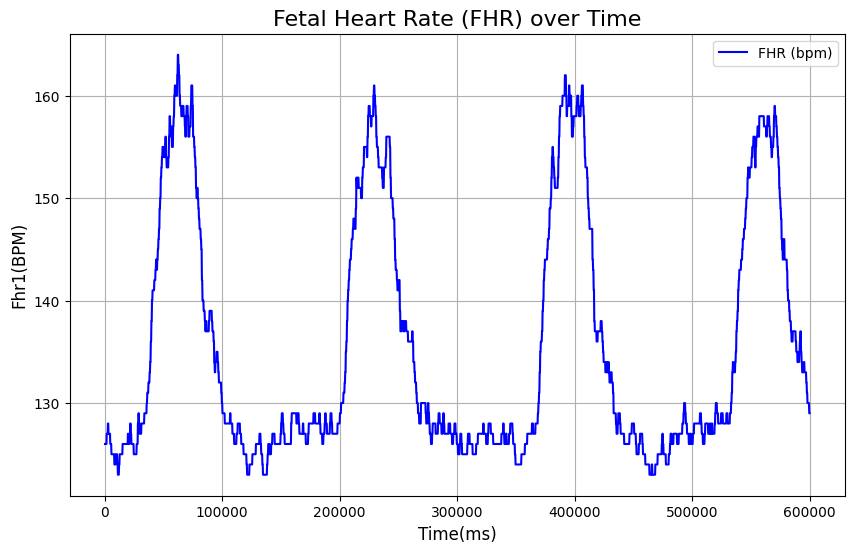

In [27]:
# Plot FHR over Time
plt.figure(figsize=(10, 6))
plt.plot(df['Time(ms)'], df['Fhr1(BPM)'], color='blue', label='FHR (bpm)')
plt.title('Fetal Heart Rate (FHR) over Time', fontsize=16)
plt.xlabel('Time(ms)', fontsize=12)
plt.ylabel('Fhr1(BPM)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

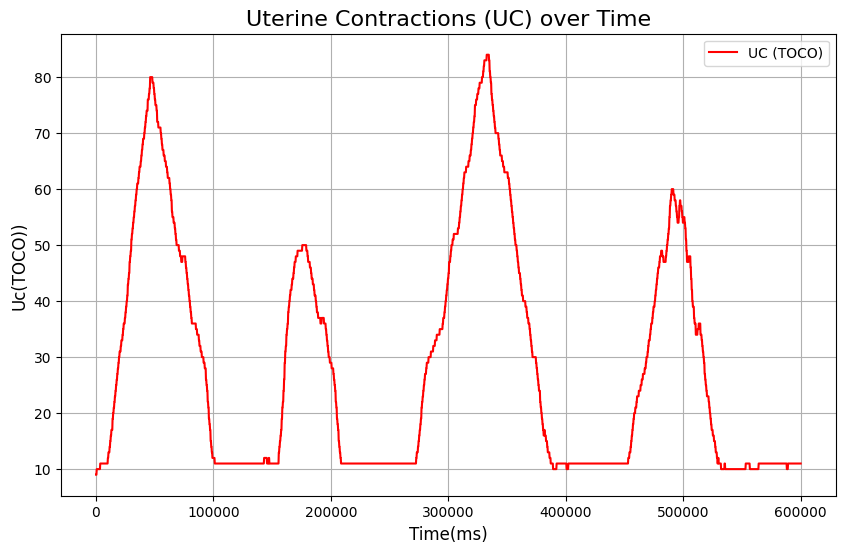

In [28]:
# Plot UC (TOCO) over Time
plt.figure(figsize=(10, 6))
plt.plot(df['Time(ms)'], df['Uc(TOCO)'], color='red', label='UC (TOCO)')
plt.title('Uterine Contractions (UC) over Time', fontsize=16)
plt.xlabel('Time(ms)', fontsize=12)
plt.ylabel('Uc(TOCO))', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## FHR Analysis

In [29]:
def analyze_fhr_epochs(df, epoch_duration_ms=3750):
   
    # Calculate number of epochs
    total_time = df['Time(ms)'].max()
    num_epochs = total_time // epoch_duration_ms

    epoch_results = []
    
    # Loop over each epoch
    for epoch in range(int(num_epochs)):
        # Calculate the start and end time for each epoch
        start_time = epoch * epoch_duration_ms
        end_time = start_time + epoch_duration_ms
        
        # Subset the data for this epoch
        epoch_data = df[(df['Time(ms)'] >= start_time) & (df['Time(ms)'] < end_time)]
        
        # Calculate average FHR for the epoch
        avg_fhr_bpm = epoch_data['Fhr1(BPM)'].mean()
        
        # Calculate the average pulse interval (ms)
        if avg_fhr_bpm > 0:  # Prevent division by zero
            avg_pulse_interval_ms = (60 / avg_fhr_bpm) * 1000
        else:
            avg_pulse_interval_ms = None
        
        # Store the results for this epoch
        epoch_results.append({
            'Epoch': epoch + 1,
            'Avg FHR (bpm)': avg_fhr_bpm,
            'Avg Pulse Interval (ms)': avg_pulse_interval_ms
        })

    # Convert the results into a DataFrame
    epoch_df = pd.DataFrame(epoch_results)
    return epoch_df



In [30]:

# Assuming df_generated is the DataFrame with Time and FHR data
epoch_df = analyze_fhr_epochs(df)
epoch_df

,Epoch,Avg FHR (bpm),Avg Pulse Interval (ms)
0,1,126.714286,473.506201
1,2,125.800000,476.947536
2,3,124.600000,481.540931
3,4,124.333333,482.573727
4,5,125.933333,476.442562
...,...,...,...
155,156,138.800000,432.276657
156,157,136.666667,439.024390
157,158,134.866667,444.883836
158,159,133.800000,448.430493


## UC Peak Detection

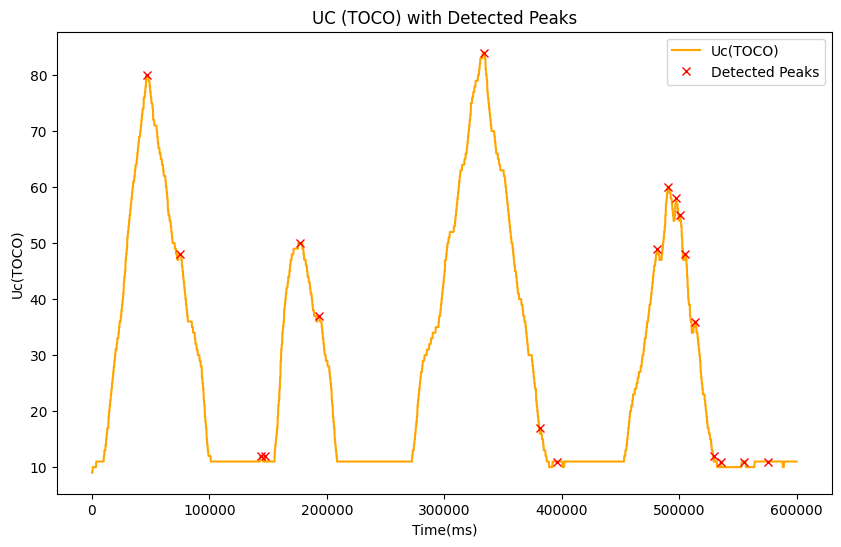

{'Total Peaks Detected': 19, 'Peaks Wider than 30 seconds': 4, 'Average Width of Peaks (ms)': np.float64(4.534375)}


In [33]:

from scipy.signal import find_peaks, peak_widths

def detect_uc_peaks(df, time_interval_ms=250, min_width_ms=30000):

    # Extract UC (TOCO) values and Time (ms)
    uc_data = df['Uc(TOCO)'].values
    time_data = df['Time(ms)'].values

    # Detect peaks in the UC data
    peaks, _ = find_peaks(uc_data)

    # Calculate the width of the peaks at half the peak height
    results_half = peak_widths(uc_data, peaks, rel_height=0.5)

    # Convert the width from indices to milliseconds
    peak_widths_ms = results_half[0] * time_interval_ms

    # Find peaks where width > 30 seconds (30000 ms)
    wide_peaks = peak_widths_ms > min_width_ms
    wide_peak_widths = peak_widths_ms[wide_peaks]

    # Calculate the average width of peaks wider than 30 seconds
    avg_peak_width_ms = wide_peak_widths.mean() if len(wide_peak_widths) > 0 else 0

    # Plot the UC data and the detected peaks
    plt.figure(figsize=(10, 6))
    plt.plot(time_data, uc_data, label='Uc(TOCO)', color='orange')
    plt.plot(time_data[peaks], uc_data[peaks], "x", label='Detected Peaks', color='red')
    plt.title('UC (TOCO) with Detected Peaks')
    plt.xlabel('Time(ms)')
    plt.ylabel('Uc(TOCO)')
    plt.legend()
    plt.show()

    return {
        "Total Peaks Detected": len(peaks),
        "Peaks Wider than 30 seconds": len(wide_peak_widths),
        "Average Width of Peaks (ms)": avg_peak_width_ms/10000
    }

# Assuming df_generated is the DataFrame with Time and UC data
uc_peak_analysis = detect_uc_peaks(df)

# Display the results
print(uc_peak_analysis)
